In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")


In [2]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)

In [3]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


## 2. k-NN

### Ajuste com GridSearchCV
GridSearch aplicado para encontrar a melhor combinação de `n_neighbors`, `weights`, `metric`, `leaf_size`. Métrica: `f1_macro`.

In [7]:

def run_grid_search(X, y, model, param_grid, cv=3, scoring='f1_macro'):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=3,
        n_jobs=-1,
        return_train_score=True
    )
    
    start = time.time()
    grid.fit(X, y)
    duration = time.time() - start

    # Resultados
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by="mean_test_score", ascending=False)

    print("\nMelhores parâmetros encontrados:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"\nMelhor {scoring}: {grid.best_score_:.4f}")
    print(f"Tempo total: {duration:.2f} segundos")

    # Top 10
    display_columns = [
        'mean_test_score', 'mean_train_score', 'std_test_score'
    ] + [col for col in results_df.columns if col.startswith('param_')]

    print("\nTop 10 combinações:")
    display(results_df[display_columns].head(10))

    return grid, results_df


In [5]:
param_grid_knn_1 = {
    'n_neighbors': [3, 9, 15],                     # Amostragem binária
    'weights': ['uniform', 'distance'],           # Dois comportamentos principais
    'metric': ['euclidean', 'manhattan'],         # Sem p
    'leaf_size': [20, 40],                         # Controle de performance
    'algorithm': ['auto']                          # Deixe o sklearn escolher
}

knn_model = KNeighborsClassifier()
grid, results_df = run_grid_search(X_train, y_train, knn_model, param_grid_knn_1)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 2/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.878) total time=  20.5s
[CV 2/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.878) total time=  20.5s
[CV 1/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, weights=distance;, score=(train=0.995, test=0.905) total time=  21.4s
[CV 1/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=9, weights=distance;, score=(train=0.995, test=0.884) total time=  20.7s
[CV 1/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=3, weights=distance;, score=(train=0.995, test=0.905) total time=  21.4s
[CV 1/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=9, weights=distance;, score=(train=0.995, test=0.884) total time=  20.7s
[CV 2/2] END algorithm=auto, leaf_size=20, metric=euclidean, n_

,mean_test_score,mean_train_score,std_test_score,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_weights
7,0.906589,0.999986,0.006112,auto,20,manhattan,3,distance
19,0.906589,0.999986,0.006112,auto,40,manhattan,3,distance
18,0.901440,0.922712,0.000705,auto,40,manhattan,3,uniform
6,0.901440,0.922712,0.000705,auto,20,manhattan,3,uniform
1,0.899627,0.997634,0.005307,auto,20,euclidean,3,distance
13,0.899627,0.997634,0.005307,auto,40,euclidean,3,distance
12,0.895484,0.916668,0.005497,auto,40,euclidean,3,uniform
0,0.895484,0.916668,0.005497,auto,20,euclidean,3,uniform
15,0.881050,0.997634,0.003331,auto,40,euclidean,9,distance
3,0.881050,0.997634,0.003331,auto,20,euclidean,9,distance


In [12]:
param_grid_knn_2 = {
    'n_neighbors': [1, 5, 7],
    'weights': ['distance'],
    'metric': ['manhattan'],
    'leaf_size': [30],
    'algorithm': ['auto'] 
}


knn_model = KNeighborsClassifier()
grid, results_df = run_grid_search(X_train, y_train, knn_model, param_grid_knn_2)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=1, weights=distance;, score=(train=1.000, test=0.910) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=7, weights=distance;, score=(train=0.996, test=0.883) total time= 2.3min
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=1, weights=distance;, score=(train=1.000, test=0.910) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=7, weights=distance;, score=(train=0.996, test=0.883) total time= 2.3min
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.908) total time= 2.3min
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.908) total time= 2.3min
[CV 3/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_ne

,mean_test_score,mean_train_score,std_test_score,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_weights
0,0.915813,0.998776,0.017424,auto,30,manhattan,1,distance
1,0.888312,0.998818,0.017703,auto,30,manhattan,5,distance
2,0.882119,0.998818,0.009956,auto,30,manhattan,7,distance


In [11]:
param_grid_knn_3 = {
    'n_neighbors': [1, 2, 3],
    'weights': ['distance'],
    'metric': ['manhattan'],
    'leaf_size': [30],
    'algorithm': ['auto']
}

knn_model = KNeighborsClassifier()
grid, results_df = run_grid_search(X_train, y_train, knn_model, param_grid_knn_3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.909) total time= 2.3min
[CV 1/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.909) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=1, weights=distance;, score=(train=0.996, test=0.939) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=3, weights=distance;, score=(train=0.996, test=0.913) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=1, weights=distance;, score=(train=0.996, test=0.939) total time= 2.3min
[CV 2/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=3, weights=distance;, score=(train=0.996, test=0.913) total time= 2.3min
[CV 3/3] END algorithm=auto, leaf_size=30, metric=manhattan, n_ne

,mean_test_score,mean_train_score,std_test_score,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_weights
0,0.915813,0.998776,0.017424,auto,30,manhattan,1,distance
1,0.915808,0.998818,0.017425,auto,30,manhattan,2,distance
2,0.902200,0.998818,0.012324,auto,30,manhattan,3,distance


### Melhor Modelo Validado


In [22]:
best_knn = KNeighborsClassifier(
    n_neighbors=2,
    weights='distance',
    metric='manhattan',
    leaf_size=30,
    algorithm='auto'
)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_val)

==== Avaliação Global (KNN) ====
Acurácia:         0.9971
Precisão:         0.9230
Recall (TPR):     0.8561
F1-Score:         0.8826
FPR (média):      0.0010
FNR (média):      0.1439
RMSE:             0.1446
AUC (ROC):        0.9506

==== Relatório por Categoria ====
              precision    recall  f1-score   support

         DoS     0.9990    0.9996    0.9993      9186
       Probe     0.9957    0.9936    0.9946      2331
         R2L     0.9568    0.8894    0.9219       199
         U2R     0.6667    0.4000    0.5000        10
      normal     0.9967    0.9981    0.9974     13469

    accuracy                         0.9971     25195
   macro avg     0.9230    0.8561    0.8826     25195
weighted avg     0.9970    0.9971    0.9970     25195



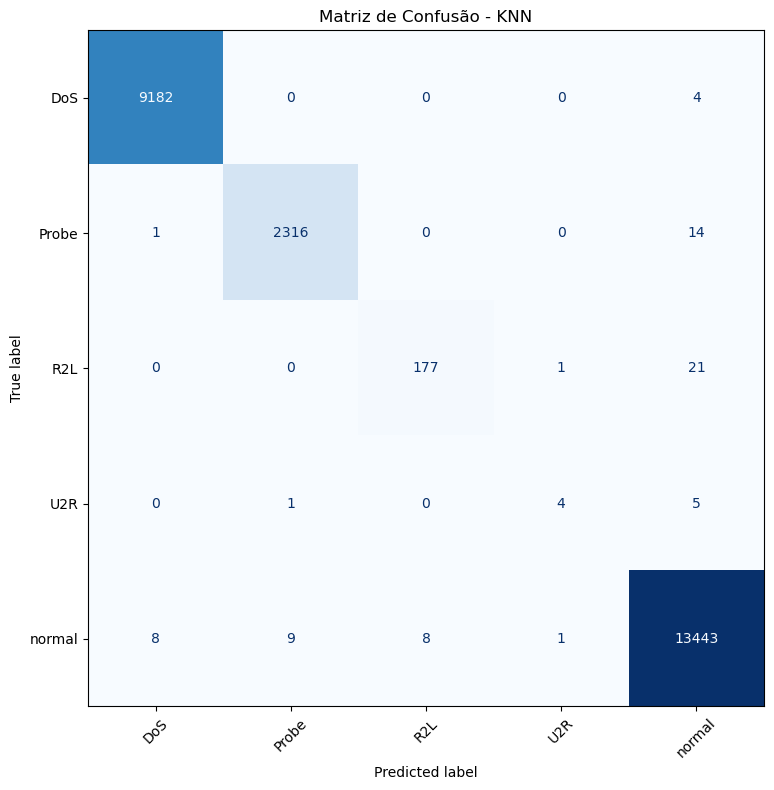

In [23]:
le = LabelEncoder()
y_val_enc = le.fit_transform(y_val)
y_pred_enc = le.transform(y_pred)

# Probabilidades para cálculo da AUC
y_proba = best_knn.predict_proba(X_val)

# Métricas principais
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred_enc))

# Matriz de confusão para FPR, FNR
cm = confusion_matrix(y_val_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Taxas derivadas
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall  # já calculado

# AUC (apenas para multiclass com probas)
try:
    auc = roc_auc_score(y_val_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

# Impressão dos resultados
print("==== Avaliação Global (KNN) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

print("\n==== Relatório por Categoria ====")
print(classification_report(y_val, y_pred, digits=4))

# Matriz de confusão por rótulo original
labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - KNN")
plt.grid(False)
plt.tight_layout()
plt.show()

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9967    0.9981    0.9974     13469
      attack     0.9978    0.9962    0.9970     11726

    accuracy                         0.9972     25195
   macro avg     0.9973    0.9972    0.9972     25195
weighted avg     0.9972    0.9972    0.9972     25195



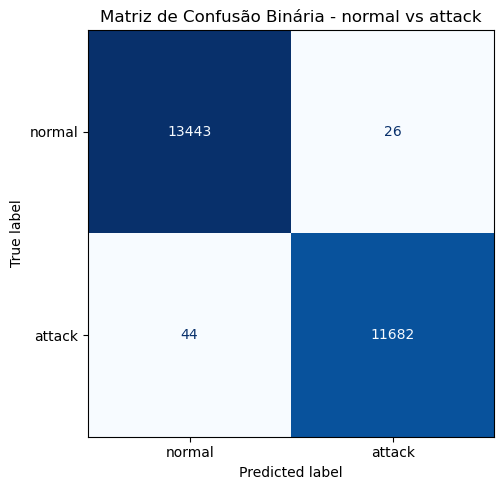

In [15]:
# Gera rótulos binários: 0 = normal, 1 = ataque
y_val_bin = y_val.apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred, index=y_val.index).apply(lambda x: 0 if x == "normal" else 1)

# Relatório binário
print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

# Matriz de confusão binária
cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - normal vs attack")
plt.grid(False)
plt.tight_layout()
plt.show()


### Avaliação Final com KDDTest+
Aplicação direta do modelo no conjunto de teste. Nenhum ajuste adicional. Métricas completas calculadas.

In [16]:
best_knn = KNeighborsClassifier(
    n_neighbors=2,
    weights='distance',
    metric='manhattan',
    leaf_size=30,
    algorithm='auto'
)

best_knn.fit(X_train_final, y_train_final)
y_pred = best_knn.predict(X_test_final)


In [17]:
# Codificação necessária para RMSE e AUC
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test_final)
y_pred_enc = le.transform(y_pred)

# Proba para AUC
y_proba = best_knn.predict_proba(X_test_final)

# Métricas principais
accuracy = accuracy_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred, average='macro')
recall = recall_score(y_test_final, y_pred, average='macro')
f1 = f1_score(y_test_final, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred_enc))

# Confusion matrix para FPR e FNR
cm = confusion_matrix(y_test_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall

try:
    auc = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

print("==== Avaliação Global no Conjunto de Teste (KNN) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")


==== Avaliação Global no Conjunto de Teste (KNN) ====
Acurácia:         0.7479
Precisão:         0.6034
Recall (TPR):     0.5231
F1-Score:         0.5296
FPR (média):      0.0821
FNR (média):      0.4769
RMSE:             1.3381
AUC (ROC):        0.7390


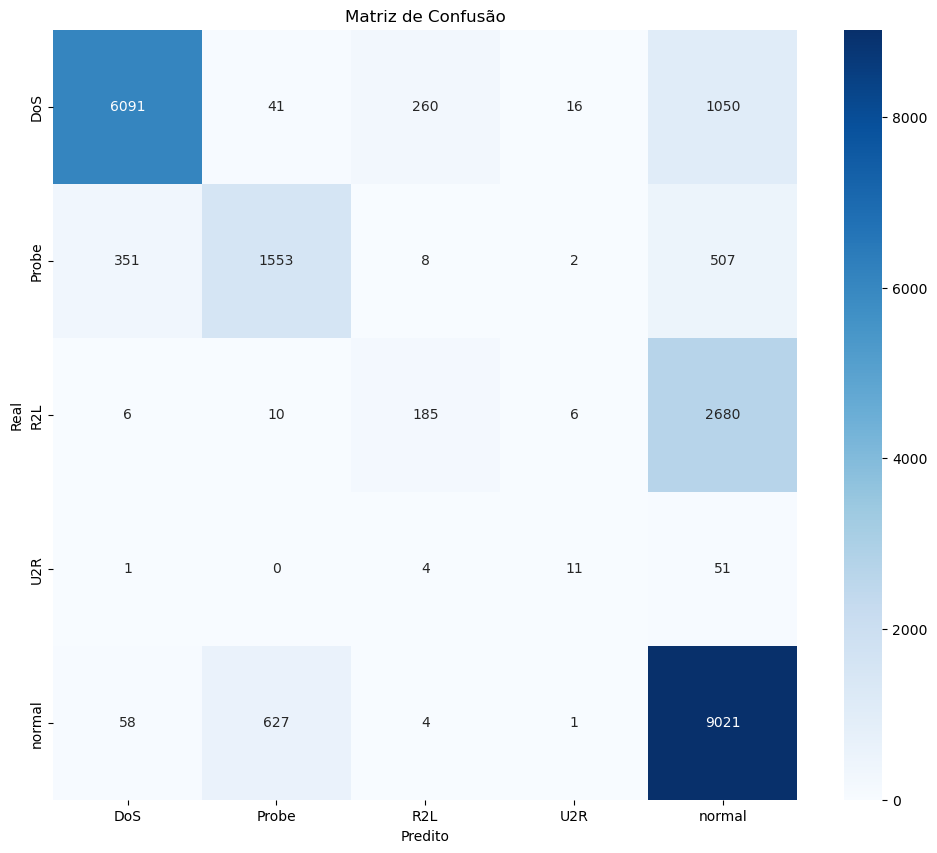

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [20]:
report = classification_report(y_test_final, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print(report_df)

              precision    recall  f1-score       support
DoS            0.936069  0.816707  0.872324   7458.000000
Probe          0.696100  0.641470  0.667670   2421.000000
R2L            0.401302  0.064080  0.110514   2887.000000
U2R            0.305556  0.164179  0.213592     67.000000
normal         0.677812  0.928947  0.783753   9711.000000
accuracy       0.747915  0.747915  0.747915      0.747915
macro avg      0.603368  0.523077  0.529571  22544.000000
weighted avg   0.728696  0.747915  0.712678  22544.000000
